## Import packages

In [178]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import scipy as scipy
#import metpy as mtp
import math
from scipy import integrate
import pandas as pd

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

time_slice = slice('1980-01-01', '2021-12-31')

### Load instantaneous AHT calcs

In [4]:
aht_ds_6hrly = xr.open_dataset('../aht_time_series/era5_aht_time_series_full.nc').sel(time=time_slice)
aht_ds_6hrly

<xarray.Dataset>
Dimensions:                     (time: 61364, latitude: 361)
Coordinates:
  * time                        (time) datetime64[ns] 1980-01-01 ... 2021-12-...
  * latitude                    (latitude) float64 90.0 89.5 ... -89.5 -90.0
Data variables: (12/18)
    total_aht                   (time, latitude) float64 ...
    eddy_aht                    (time, latitude) float64 ...
    mmc_aht                     (time, latitude) float64 ...
    total_aht_no_seasons        (time, latitude) float64 ...
    eddy_aht_no_seasons         (time, latitude) float64 ...
    mmc_aht_no_seasons          (time, latitude) float64 ...
    ...                          ...
    total_aht_dry               (time, latitude) float64 ...
    eddy_aht_dry                (time, latitude) float64 ...
    mmc_aht_dry                 (time, latitude) float64 ...
    total_aht_no_seasons_dry    (time, latitude) float64 ...
    eddy_aht_no_seasons_dry     (time, latitude) float64 ...
    mmc_aht_no_seasons_dry      (time, latitude) float64 ...

### Load Strm Fncts

In [263]:
strm_datas = []

strm_files = glob('../era5_data/strm_fncts/*')

for file in strm_files:
    strm_ds_one = xr.open_dataset(file)
    strm_datas.append(strm_ds_one)

In [264]:
strm_ds = xr.concat(strm_datas, dim='time').sortby('time').__xarray_dataarray_variable__

strm_ds_djf = strm_ds.sel(time=strm_ds.time.dt.month.isin([12, 1, 2]))
strm_ds

<xarray.DataArray '__xarray_dataarray_variable__' (time: 62824, level: 37, latitude: 361)>
array([[[-2.90087889e-18, -4.04112387e+06, -1.26249220e+07, ...,
          3.85449546e+05,  1.36592214e+05, -2.90087889e-18],
        [-4.83479815e-18, -3.32888352e+06, -1.01409464e+07, ...,
          7.59822634e+06,  2.58598370e+06, -4.83479815e-18],
        [-7.73567704e-18, -3.35166832e+06, -1.53261632e+07, ...,
          3.23934491e+06,  2.10041891e+05, -7.73567704e-18],
        ...,
        [-1.86139729e-15, -3.20557793e+07,  1.30284841e+07, ...,
         -5.96046448e-08,  1.49011612e-08, -1.32747600e-15],
        [-1.90974527e-15, -1.36885454e+07,  2.97977369e+06, ...,
         -5.96046448e-08,  1.49011612e-08, -1.32747600e-15],
        [-1.96106126e-15,  9.31322575e-09,  2.13272870e-07, ...,
         -5.96046448e-08,  1.49011612e-08, -1.32747600e-15]],

       [[ 1.10831370e-01,  2.46048103e+06,  8.51414233e+06, ...,
         -1.02052535e+07, -2.92951026e+06,  1.11475517e-01],
        [ 1.84718950e-01,  9.36242093e+05,  4.01880536e+06, ...,
         -2.90623795e+06, -1.06263353e+06,  1.85792528e-01],
        [ 1.53564309e-01, -2.44569591e+06, -7.95101346e+06, ...,
         -1.83933416e+07, -5.32055604e+06,  1.55282034e-01],
...
        [ 1.55115692e-01, -2.81001341e+07, -5.21237162e+07, ...,
         -1.49011612e-07,  0.00000000e+00, -2.77555756e-17],
        [ 7.98675343e-02, -2.61112875e+07, -6.75037723e+07, ...,
         -1.49011612e-07,  0.00000000e+00, -2.77555756e-17],
        [ 3.87190280e-15,  3.72529030e-09,  0.00000000e+00, ...,
         -1.49011612e-07,  0.00000000e+00, -2.77555756e-17]],

       [[-4.35131834e-18, -1.95374638e+06, -6.38439252e+06, ...,
         -1.31963189e+07, -3.73940037e+06, -1.45043945e-18],
        [-7.25219723e-18, -6.84229050e+05, -2.92625896e+06, ...,
         -9.18691923e+06, -2.65785393e+06, -2.41739908e-18],
        [-1.16035156e-17, -2.45771034e+06, -8.99210161e+06, ...,
         -1.06662416e+07, -2.78424482e+06, -3.86783852e-18],
        ...,
        [-2.79209593e-15,  4.36063380e+07,  1.50054063e+08, ...,
          5.96046448e-08,  1.49011612e-08, -6.63737998e-16],
        [-2.86461790e-15,  2.56115911e+07,  6.94619275e+07, ...,
          5.96046448e-08,  1.49011612e-08, -6.63737998e-16],
        [-2.94159190e-15, -7.45058060e-09,  0.00000000e+00, ...,
          5.96046448e-08,  1.49011612e-08, -6.63737998e-16]]])
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01 ... 2021-12-31T18:00:00
  * latitude  (latitude) float32 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5 -90.0
  * level     (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000

In [265]:
strm_ds_anom = strm_ds.groupby('time.dayofyear') - strm_ds.groupby('time.dayofyear').mean('time')

In [266]:
aht_ds_anom = aht_ds_6hrly.groupby('time.dayofyear') - aht_ds_6hrly.groupby('time.dayofyear').mean('time')

In [267]:
aht_ds_anom_djf = aht_ds_anom.sel(time=aht_ds_anom.time.dt.month.isin([12, 1, 2]))
aht_ds_djf = aht_ds_6hrly.sel(time=aht_ds_6hrly.time.dt.month.isin([12, 1, 2]))

aht_all_times = aht_ds_djf.time.values

In [292]:
which_lat = 50

aht_ds_lat = aht_ds_anom_djf.sel(latitude=which_lat)

aht_times = aht_ds_lat.eddy_aht_no_seasons.sortby(aht_ds_lat.eddy_aht_no_seasons, ascending=False)[:int(0.06 * len(aht_ds_lat.total_aht))]

aht_times_idxs = np.searchsorted(aht_all_times, aht_times.time.values)

In [293]:
new_times = []

for time in aht_times_idxs:
    add_flag = True
    for i in np.arange(-5, 6, 1):
        if time + i in new_times:
            add_flag = False
    if add_flag == True:
        new_times.append(time)
        
#new_times

aht_times_idxs = np.array(new_times)

In [294]:
num_lags = 17

eddy_array = np.zeros((361, 2 * num_lags - 1))
mmc_array = np.zeros((361, 2 * num_lags - 1))

for idx, lag in enumerate(np.arange(-16, 17, 1)):
    try:
        eddy_one = aht_ds_anom_djf.eddy_aht_no_seasons.isel(time=aht_times_idxs + lag)
        mmc_one = aht_ds_anom_djf.mmc_aht_no_seasons.isel(time=aht_times_idxs + lag)
    except IndexError:
        print('Error')
    
    eddy_array[:, idx] = eddy_one.mean('time').values
    mmc_array[:, idx] = mmc_one.mean('time').values

In [295]:
#aht_times_subset = aht_times.sortby('time').sel(time=slice('2019-01-01', '2021-12-31'))


strm_ds_anom_subset = strm_ds_anom.sel(time=aht_times.time.values)


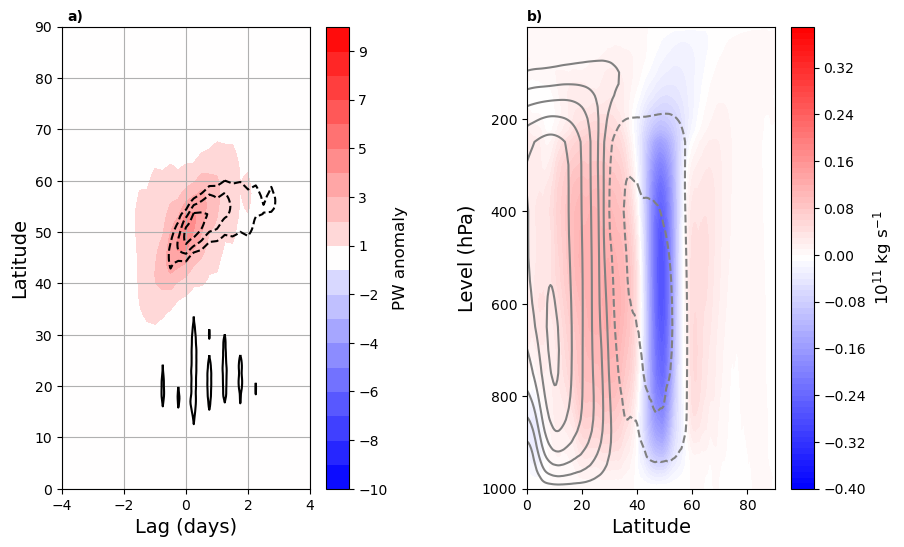

In [329]:
contf_levels = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
cont_levels = [-3, -2.5, -2, -1.5, -1.25, -1, -0.75, 0.75, 1, 1.25, 1.5, 2]

panel_order = [['A', 'B']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

contf=axs['A'].contourf(np.linspace(-4, 4, 33), lats, eddy_array / 1e15, levels=contf_levels, cmap='bwr')
axs['A'].contour(np.linspace(-4, 4, 33), lats, mmc_array / 1e15, levels=cont_levels, colors='k')
#plt.contour(np.linspace(-4, 4.1, 33), lats, mmc_array / 1e15, levels=np.linspace(-2, 2, 10), cmap='bwr')

axs['A'].set_ylim([0, 90])
axs['A'].grid()

plt.colorbar(contf,  ax=axs['A']).set_label(label='PW anomaly', size=12)

axs['A'].set_ylabel('Latitude', fontsize=14)
axs['A'].set_xlabel('Lag (days)', fontsize=14)

strm_contours = [-2.5, -2.0, -1.5, -1.0, -.6, -.3, -.1, .1, .3, .6, 1.0, 1.5, 2.0, 2.5]

axs['B'].contour(lats, levels, strm_ds_djf.mean('time') / 1e11, colors='grey', levels=strm_contours)
contf_strm=axs['B'].contourf(lats, levels, strm_ds_anom_subset.mean('time') / 1e11, cmap='bwr',
                 levels=np.arange(-0.4, 0.4, .01))

axs['B'].invert_yaxis()

axs['B'].set_xlim([0, 90])
axs['B'].set_xlabel('Latitude', fontsize=14)
axs['B'].set_ylabel('Level (hPa)', fontsize=14)

plt.colorbar(contf_strm, ax=axs['B']).set_label(label='10$^{11}$ kg s$^{-1}$', size=12)

plt.subplots_adjust(wspace=0.5)

fig.text(0.13, 0.89, 'a)', fontweight='semibold')
fig.text(0.59, 0.89, 'b)', fontweight='semibold')

#fig.tight_layout()
#plt.savefig('figures/mmc_eddy_composite_with_strm')
plt.show()

In [279]:
aht_ds_djf = aht_ds_6hrly.sel(time=aht_ds_6hrly.time.dt.month.isin([11, 12, 1, 2]))
aht_ds_jja = aht_ds_6hrly.sel(time=aht_ds_6hrly.time.dt.month.isin([6, 7, 8]))

In [280]:
slopes_djf = np.zeros(len(lats))
r_values_djf = np.zeros(len(lats))
slopes_jja = np.zeros(len(lats))
r_values_jja = np.zeros(len(lats))

eddy_field_djf = aht_ds_djf.eddy_aht_no_seasons.values
mmc_field_djf = aht_ds_djf.mmc_aht_no_seasons.values

eddy_field_jja = aht_ds_jja.eddy_aht_no_seasons.values
mmc_field_jja = aht_ds_jja.mmc_aht_no_seasons.values

for i in range(len(lats)):
    slopes_djf[i], intercept, r_values_djf[i], p_value, std_err = sc.linregress(eddy_field_djf[:,i]/1e15,
                                                                                mmc_field_djf[:,i]/1e15)
    slopes_jja[i], intercept, r_values_jja[i], p_value, std_err = sc.linregress(eddy_field_jja[:,i]/1e15,
                                                                                mmc_field_jja[:,i]/1e15)
    

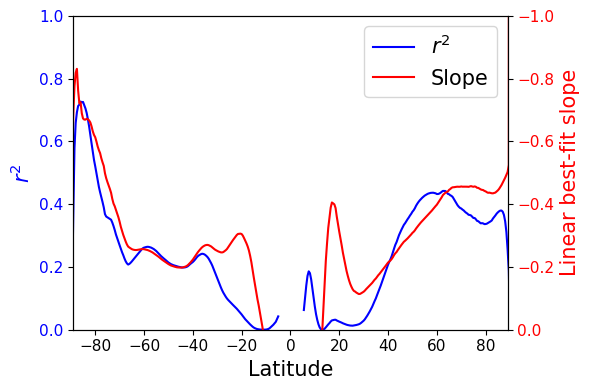

In [281]:
fig, axs = plt.subplots(1, 1, figsize=(6,4))

axs.plot(lats[:170], (r_values_djf**2)[:170], 'b', label='$r^2$')
axs.plot(lats[190:], (r_values_jja**2)[190:], 'b')
axs.plot(lats + 200, r_values**2, 'r', label='Slope')
axs.set_xlim([-89, 89])
axs.set_ylim([0, 1])
axs11 = axs.twinx()
axs11.plot(lats[:170], slopes_djf[:170], color='r')
axs11.plot(lats[190:], slopes_jja[190:], color='r')
axs11.invert_yaxis()
axs11.set_ylim([0, -1])
axs.legend(loc=0, fontsize=15)

# Change color of each axis
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)

color_y_axis(axs, 'b')
color_y_axis(axs11, 'r')
axs.set_xlabel('Latitude', fontsize=15)
axs.set_ylabel('$r^2$', fontsize=15, color='b')
axs11.set_ylabel('Linear best-fit slope', fontsize=15, color='r')

axs.tick_params(axis='both', which='major', labelsize=11)
axs11.tick_params(axis='both', which='major', labelsize=11)

#axs.set_title('Eddy vs. MMC correlations')

#plt.suptitle('Eddy and MMC correlations')
plt.tight_layout()

#fig.text(x=0.08, y=0.9, s='a)', fontweight='bold')
#fig.text(x=0.57, y=0.86, s='b)', fontweight='bold')

#plt.savefig('figures/mmc_eddy_slopes')
plt.show()

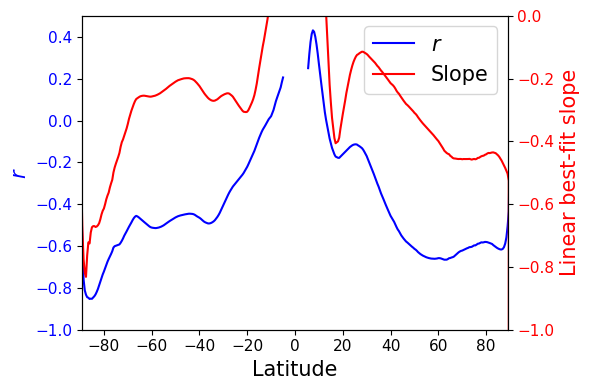

In [307]:
fig, axs = plt.subplots(1, 1, figsize=(6,4))

axs.plot(lats[:170], (r_values_djf)[:170], 'b', label='$r$')
axs.plot(lats[190:], (r_values_jja)[190:], 'b')
axs.plot(lats + 200, r_values, 'r', label='Slope')
axs.set_xlim([-89, 89])
axs.set_ylim([-1, 0.5])
#axs.invert_yaxis()
axs11 = axs.twinx()
axs11.plot(lats[:170], slopes_djf[:170], color='r')
axs11.plot(lats[190:], slopes_jja[190:], color='r')
#axs11.invert_yaxis()
axs11.set_ylim([-1, 0])
axs.legend(loc=0, fontsize=15)

# Change color of each axis
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)

color_y_axis(axs, 'b')
color_y_axis(axs11, 'r')
axs.set_xlabel('Latitude', fontsize=15)
axs.set_ylabel('$r$', fontsize=15, color='b')
axs11.set_ylabel('Linear best-fit slope', fontsize=15, color='r')

axs.tick_params(axis='both', which='major', labelsize=11)
axs11.tick_params(axis='both', which='major', labelsize=11)

#axs.set_title('Eddy vs. MMC correlations')

#plt.suptitle('Eddy and MMC correlations')
plt.tight_layout()

#fig.text(x=0.08, y=0.9, s='a)', fontweight='bold')
#fig.text(x=0.57, y=0.86, s='b)', fontweight='bold')

#plt.savefig('figures/mmc_eddy_slopes')
plt.show()

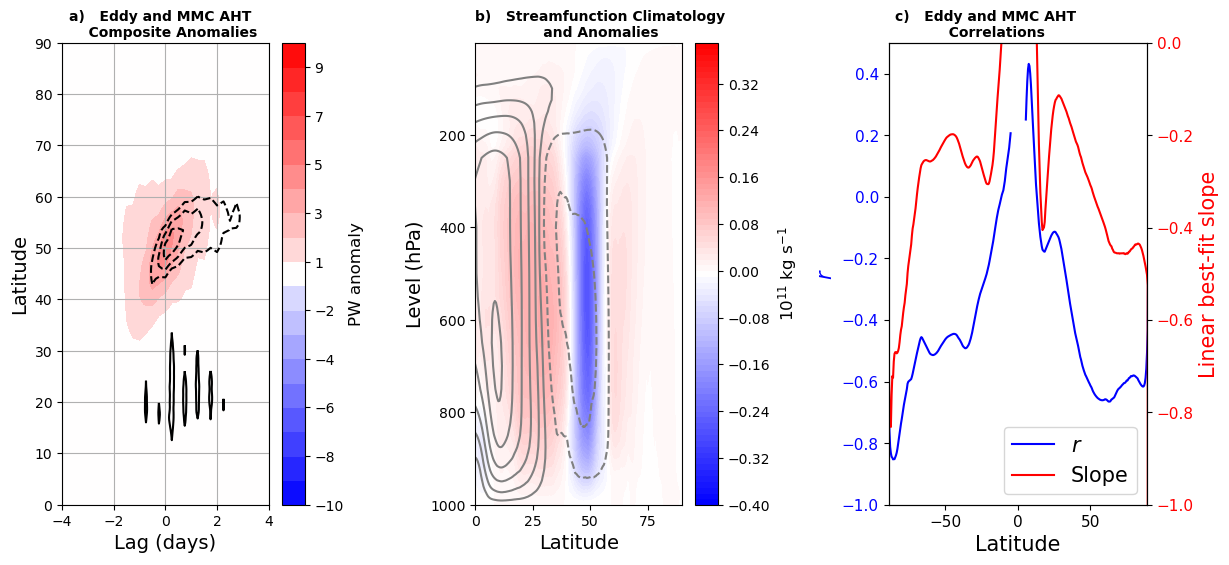

In [343]:
contf_levels = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
cont_levels = [-3, -2.5, -2, -1.5, -1.25, -1, -0.75, 0.75, 1, 1.25, 1.5, 2]

panel_order = [['A', 'B', 'C']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(14, 6))

contf=axs['A'].contourf(np.linspace(-4, 4, 33), lats, eddy_array / 1e15, levels=contf_levels, cmap='bwr')
axs['A'].contour(np.linspace(-4, 4, 33), lats, mmc_array / 1e15, levels=cont_levels, colors='k')
#plt.contour(np.linspace(-4, 4.1, 33), lats, mmc_array / 1e15, levels=np.linspace(-2, 2, 10), cmap='bwr')

axs['A'].set_ylim([0, 90])
axs['A'].grid()

plt.colorbar(contf,  ax=axs['A']).set_label(label='PW anomaly', size=12)

axs['A'].set_ylabel('Latitude', fontsize=14)
axs['A'].set_xlabel('Lag (days)', fontsize=14)

strm_contours = [-2.5, -2.0, -1.5, -1.0, -.6, -.3, -.1, .1, .3, .6, 1.0, 1.5, 2.0, 2.5]

axs['B'].contour(lats, levels, strm_ds_djf.mean('time') / 1e11, colors='grey', levels=strm_contours)
contf_strm=axs['B'].contourf(lats, levels, strm_ds_anom_subset.mean('time') / 1e11, cmap='bwr',
                 levels=np.arange(-0.4, 0.4, .01))

axs['B'].invert_yaxis()

axs['B'].set_xlim([0, 90])
axs['B'].set_xlabel('Latitude', fontsize=14)
axs['B'].set_ylabel('Level (hPa)', fontsize=14)

plt.colorbar(contf_strm, ax=axs['B']).set_label(label='10$^{11}$ kg s$^{-1}$', size=12)


axs['C'].plot(lats[:170], (r_values_djf)[:170], 'b', label='$r$')
axs['C'].plot(lats[190:], (r_values_jja)[190:], 'b')
axs['C'].plot(lats + 200, r_values, 'r', label='Slope')
axs['C'].set_xlim([-89, 89])
axs['C'].set_ylim([-1, 0.5])
#axs.invert_yaxis()
axs11 = axs['C'].twinx()
axs11.plot(lats[:170], slopes_djf[:170], color='r')
axs11.plot(lats[190:], slopes_jja[190:], color='r')
#axs11.invert_yaxis()
axs11.set_ylim([-1, 0])
axs['C'].legend(loc=0, fontsize=15)

# Change color of each axis
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)

color_y_axis(axs['C'], 'b')
color_y_axis(axs11, 'r')
axs['C'].set_xlabel('Latitude', fontsize=15)
axs['C'].set_ylabel('$r$', fontsize=15, color='b')
axs11.set_ylabel('Linear best-fit slope', fontsize=15, color='r')

axs['C'].tick_params(axis='both', which='major', labelsize=11)
axs11.tick_params(axis='both', which='major', labelsize=11)

plt.subplots_adjust(wspace=0.6)

fig.text(0.13, 0.89, 'a)   Eddy and MMC AHT \n    Composite Anomalies', fontweight='semibold')
fig.text(0.42, 0.89, 'b)   Streamfunction Climatology \n              and Anomalies', fontweight='semibold')
fig.text(0.72, 0.89, 'c)   Eddy and MMC AHT \n           Correlations', fontweight='semibold')

#fig.tight_layout()
#plt.savefig('figures/mmc_eddy_combo_figure')
plt.show()